In [1]:
import sys
import os
import math
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import math

import tensorflow as tf
from tensorflow import keras

from bs4 import BeautifulSoup
from bs4.element import Comment
import re
from langdetect import detect_langs
import nltk
from nltk.corpus import stopwords


from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

from process_websites import get_corpus
from my_models import categoryDetection, unify_yelp_data_classes, plot_classes_distribution, testing, find_wrongs, get_classes_distribution


try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    if sys.version_info > (3.0):
        os.system('python3 -m nltk.downloader stopwords')
    else:
        os.system('pyhton -m nltk.downloader.stopwords')
        
FOLDER_PATH = '/home/vahidsanei_google_com/'

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

In [3]:
!python -m nltk.downloader stopwords

/opt/conda/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vahidsanei_google_com/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df = pd.read_csv('/home/vahidsanei_google_com/data/yelp_data/updated_large/business_with_corpus.csv')
df.head()

,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,url,webpage_text,is_eng,webpage_corpus
0,0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'...",http://www.therangeatlakenorman.com/,"b'<!DOCTYPE html>\n<html lang=""en-US"">\n<head>...",True,Shooting Ranges Gun Rental Charlotte NC The Ra...
1,1,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,5,1,NaN,"Pets, Pet Services, Pet Groomers",NaN,http://www.felinus.ca,"b'<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0...",False,NaN
2,2,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726648,4.5,26,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Home Services, Plumbing, Electricians, Handyma...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '...",https://www.usemyguyservices.com,"b'<!DOCTYPE html>\n<html lang=""en-US"" prefix=""...",True,Home Renovations and Repairs Phoenix AZ Home U...
3,3,cKyLV5oWZJ2NudWgqs8VZw,Oasis Auto Center - Gilbert,"1720 W Elliot Rd, Ste 105",Gilbert,AZ,85233,33.350399,-111.827142,4.5,38,1,{'BusinessAcceptsCreditCards': 'True'},"Auto Repair, Automotive, Oil Change Stations, ...","{'Monday': '7:0-18:0', 'Tuesday': '7:0-18:0', ...",http://oasisautocenter.net,"b'<!DOCTYPE html>\n<html lang=""en-US"" prefix=""...",True,Home Oasis Auto CenterOasis Auto Center Pages ...
4,4,ScYkbYNkDgCneBrD9vqhCQ,Junction Tire & Auto Service,6910 E Southern Ave,Mesa,AZ,85209,33.393885,-111.682226,5.0,18,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Auto Repair, Oil Change Stations, Automotive, ...","{'Monday': '7:30-17:0', 'Tuesday': '7:30-17:0'...",http://junctiontire.net/tires-auto-repair-mesa-az,"b'<!DOCTYPE html>\r\n<html lang=""en"">\r\n<head...",True,Contact Junction Tire Tires Auto Repair Shop i...


In [5]:
df.columns

Index(['Unnamed: 0', 'business_id', 'name', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'stars', 'review_count',
       'is_open', 'attributes', 'categories', 'hours', 'url', 'webpage_text',
       'is_eng', 'webpage_corpus'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78568 entries, 0 to 78567
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      78568 non-null  int64  
 1   business_id     78568 non-null  object 
 2   name            78568 non-null  object 
 3   address         75147 non-null  object 
 4   city            78568 non-null  object 
 5   state           78568 non-null  object 
 6   postal_code     78410 non-null  object 
 7   latitude        78568 non-null  float64
 8   longitude       78568 non-null  float64
 9   stars           78568 non-null  float64
 10  review_count    78568 non-null  int64  
 11  is_open         78568 non-null  int64  
 12  attributes      67645 non-null  object 
 13  categories      78514 non-null  object 
 14  hours           67573 non-null  object 
 15  url             78568 non-null  object 
 16  webpage_text    78568 non-null  object 
 17  is_eng          78568 non-null 

In [7]:
for url, corpus in zip(df['url'][-10:], df['webpage_corpus'][-10:]):
    try:
        print(url)
        print('#' * 50)
        print(corpus[:1000])
        print('*' * 50)
    except:
        pass

http://www.thedakotaatcamelback.com
##################################################
Sorry An error has occured No domain data found for domain wwwthedakotaatcamelbackcom 2020 RentPath LLC All rights reserved All photos videos and floor plans are the property of RentPath LLC All text is the property of this property RentPath is in no way affiliated with the management or ownership of this property
**************************************************
http://www.alyshaan.com
##################################################
https://www.kfc.ca//store/415-mount-pleasant-rd-toronto
##################################################
Be A Franais Sign in FOR SHARING FOR ONE DEALS 0 000 START MY ORDER 415 Mount Pleasant Rd Hours Sunday 1100 AM1000 PM Monday 1100 AM1000 PM Tuesday 1100 AM1000 PM Wednesday 1100 AM1000 PM Thursday 1100 AM1000 PM Friday 1100 AM1000 PM Saturday 1100 AM1000 PM 415 Mount Pleasant Rd 4164810900 Choose Another Location Store Details 415 Mount Pleasant Rd Toronto ON M4

In [8]:
df_sentsplit = pd.read_csv('/home/vahidsanei_google_com/data/yelp_data/updated_large/business_with_corpus_sent_split.csv')
df_sentsplit.head()

,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,url,webpage_text,is_eng,webpage_corpus
0,0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'...",http://www.therangeatlakenorman.com/,"b'<!DOCTYPE html>\n<html lang=""en-US"">\n<head>...",True,Shooting Ranges Gun Rental Charlotte NC The Ra...
1,1,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,5,1,NaN,"Pets, Pet Services, Pet Groomers",NaN,http://www.felinus.ca,"b'<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0...",False,NaN
2,2,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726648,4.5,26,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Home Services, Plumbing, Electricians, Handyma...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '...",https://www.usemyguyservices.com,"b'<!DOCTYPE html>\n<html lang=""en-US"" prefix=""...",True,Home Renovations and Repairs Phoenix AZ Home U...
3,3,cKyLV5oWZJ2NudWgqs8VZw,Oasis Auto Center - Gilbert,"1720 W Elliot Rd, Ste 105",Gilbert,AZ,85233,33.350399,-111.827142,4.5,38,1,{'BusinessAcceptsCreditCards': 'True'},"Auto Repair, Automotive, Oil Change Stations, ...","{'Monday': '7:0-18:0', 'Tuesday': '7:0-18:0', ...",http://oasisautocenter.net,"b'<!DOCTYPE html>\n<html lang=""en-US"" prefix=""...",True,Home Oasis Auto CenterOasis Auto Center Pages ...
4,4,ScYkbYNkDgCneBrD9vqhCQ,Junction Tire & Auto Service,6910 E Southern Ave,Mesa,AZ,85209,33.393885,-111.682226,5.0,18,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Auto Repair, Oil Change Stations, Automotive, ...","{'Monday': '7:30-17:0', 'Tuesday': '7:30-17:0'...",http://junctiontire.net/tires-auto-repair-mesa-az,"b'<!DOCTYPE html>\r\n<html lang=""en"">\r\n<head...",True,Contact Junction Tire Tires Auto Repair Shop i...


In [9]:
for url, corpus in zip(df['url'][-5:], df['webpage_corpus'][-5:]):
    try:
        print(url)
        print('#' * 50)
        print(corpus[:1000])
        print('*' * 50)
    except:
        pass

http://www.salonfortytwo.com
##################################################
Salon 42 Home Story Services Salons Tribe 42 Weddings Our Press Contact Us Home Story Services Salons Tribe 42 Weddings Our Press Contact Us 42 The answer to life the universe and everything Especially for Hair Salon 42 New Salon Coming Soon To beautiful sunny Charleston SC But for now continue to visit us atxe2x80xa6 Southparkxe2x80xa6 Charlotte NC Indian Landxe2x80xa6Indian Land SC Dilworth xe2x80xa6 Charlotte NC Lake Norman xe2x80xa6 Corneliua NC Did you know 42 people move into Charlotte everydayxe2x80xa6 yepxe2x80xa6itxe2x80x99s our magic number again and we hope to see them all here at Salon 42 What Else is New Learn About the Life of 42xe2x80xa6 42 is the answer to Life the Universe and Everything according to Douglas Adams and the book xe2x80x9cHitchhikers Guide to the Galaxy 42 degrees is the angle at which light must reflect off water in order to create a rainbow The Titanic was traveling at a spe

In [10]:
for url, corpus in zip(df_sentsplit['url'][-5:], df_sentsplit['webpage_corpus'][-5:]):
    try:
        print(url)
        print('#' * 50)
        print(corpus[:1000])
        print('*' * 50)
    except:
        pass

http://www.salonfortytwo.com
##################################################
Salon 42 Home Story Services Salons Tribe 42 Weddings Our Press Contact Us Home Story Services Salons Tribe 42 Weddings Our Press Contact Us 42 The answer to life the universe and everything#Especially for Hair Salon 42 New Salon Coming Soon To beautiful sunny Charleston SC But for now continue to visit us atxe2x80xa6 Southparkxe2x80xa6 Charlotte NC Indian Landxe2x80xa6Indian Land SC Dilworth xe2x80xa6 Charlotte NC Lake Norman xe2x80xa6 Corneliua NC Did you know#42 people move into Charlotte everydayxe2x80xa6 yepxe2x80xa6itxe2x80x99s our magic number again and we hope to see them all here at Salon 42#What Else is New#Learn About the Life of 42xe2x80xa6 42 is the answer to Life the Universe and Everything according to Douglas Adams and the book xe2x80x9cHitchhikers Guide to the Galaxy#42 degrees is the angle at which light must reflect off water in order to create a rainbow#The Titanic was traveling at a spe

In [11]:
saved_df = df.copy()
saved_df_sentsplit = df_sentsplit.copy()

In [12]:
df = saved_df.copy()
df_sentsplit = saved_df_sentsplit.copy()

In [13]:
df = unify_yelp_data_classes(df, show_skipped=False);

/home/vahidsanei_google_com/advertiser-quality-from-sites/source/my_models.py:438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['categories'] = df['categories'].apply(lambda x: re.split('[,;&]', x))
/home/vahidsanei_google_com/advertiser-quality-from-sites/source/my_models.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['categories'] = cat


In [14]:
df_sentsplit = unify_yelp_data_classes(df_sentsplit, show_skipped=False);

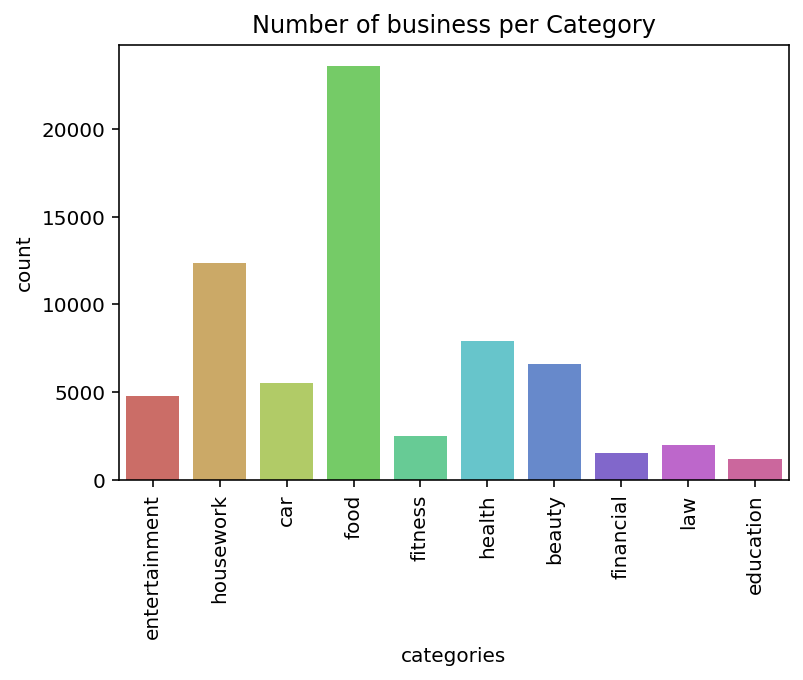

In [15]:
plot_classes_distribution(df)

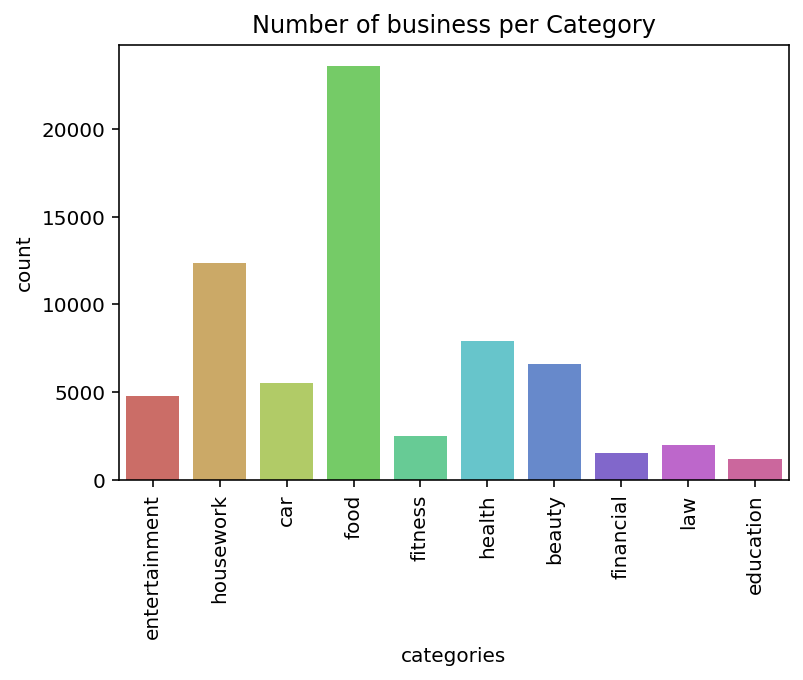

In [16]:
plot_classes_distribution(df_sentsplit)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67945 entries, 0 to 78567
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      67945 non-null  int64  
 1   business_id     67945 non-null  object 
 2   name            67945 non-null  object 
 3   address         65177 non-null  object 
 4   city            67945 non-null  object 
 5   state           67945 non-null  object 
 6   postal_code     67813 non-null  object 
 7   latitude        67945 non-null  float64
 8   longitude       67945 non-null  float64
 9   stars           67945 non-null  float64
 10  review_count    67945 non-null  int64  
 11  is_open         67945 non-null  int64  
 12  attributes      59391 non-null  object 
 13  categories      67945 non-null  object 
 14  hours           59100 non-null  object 
 15  url             67945 non-null  object 
 16  webpage_text    67945 non-null  object 
 17  is_eng          67945 non-null 

In [18]:
folder_path = os.path.join(FOLDER_PATH, 'data','uncased_L-12_H-768_A-12')
tokenizer = FullTokenizer(vocab_file=os.path.join(folder_path, 'vocab.txt'))

bert_ckpt_file = os.path.join(folder_path, 'bert_model.ckpt')
bert_config_file = os.path.join(folder_path, 'bert_config.json')

tokens_test = tokenizer.tokenize('This is an open-source project for category detection of businesses based on their website contents!')
print(tokens_test)
print(tokenizer.convert_tokens_to_ids(tokens_test))

['this', 'is', 'an', 'open', '-', 'source', 'project', 'for', 'category', 'detection', 'of', 'businesses', 'based', 'on', 'their', 'website', 'contents', '!']
[2023, 2003, 2019, 2330, 1011, 3120, 2622, 2005, 4696, 10788, 1997, 5661, 2241, 2006, 2037, 4037, 8417, 999]


In [19]:
split_sz = int(len(df) * 0.8)
train = df[:split_sz]
test = df[split_sz:]

In [20]:
cat1 = categoryDetection(train, test, tokenizer, max_seq_len=128)

34858it [07:23, 78.54it/s] 
12it [00:00, 118.32it/s]

Removed 17.875380113603768% of entries, due to being short corpus length.


8677it [01:48, 80.20it/s] 


Removed 18.047712342975686% of entries, due to being short corpus length.
size of each balanced class =  601


# Baseline with Unbalanced Training Set

In [21]:
get_classes_distribution(cat1.train_y, cat1.classes)

class beauty = 10.59%
class car = 9.11%
class education = 2.1%
class entertainment = 7.57%
class financial = 2.72%
class fitness = 4.2%
class food = 29.35%
class health = 12.16%
class housework = 19.14%
class law = 3.07%


In [22]:
model1 = cat1.build_model(bert_config_file, bert_ckpt_file, max_seq_len=128, adapter_size=None);
cat1.compile_model(model1, cat1.train_x, cat1.train_y, n_epochs=20);
print('Accuracy on test set:')
model1.evaluate(cat1.test_x, cat1.test_y);

Done loading 196 BERT weights from: /home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fc291a65210> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)          

# Baseline with Balanced Training Set

In [23]:
get_classes_distribution(cat1.balanced_train_y, cat1.classes)

class beauty = 10.0%
class car = 10.0%
class education = 10.0%
class entertainment = 10.0%
class financial = 10.0%
class fitness = 10.0%
class food = 10.0%
class health = 10.0%
class housework = 10.0%
class law = 10.0%


In [24]:
model1_bal = cat1.build_model(bert_config_file, bert_ckpt_file, max_seq_len=128, adapter_size=None)
cat1.compile_model(model1_bal, cat1.balanced_train_x, cat1.balanced_train_y, n_epochs=20)
print('Accuracy on test set:')
model1_bal.evaluate(cat1.test_x, cat1.test_y);

Done loading 196 BERT weights from: /home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fc291a65290> (prefix:bert_1). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)      

In [25]:
text = 'Restaurants are classified or distinguished in many different ways. The primary factors are usually the food itself (e.g. vegetarian, seafood, steak); the cuisine (e.g. Italian, Chinese, Japanese, Indian, French, Mexican, Thai) or the style of offering (e.g. tapas bar, a sushi train, a tastet restaurant, a buffet restaurant or a yum cha restaurant). Beyond this, restaurants may differentiate themselves on factors including speed (see fast food), formality, location, cost, service, or novelty themes (such as automated restaurants). Some of these include fine dining, casual dining, contemporary casual, family style, fast casual, fast food, cafes, buffet, concession stands, food trucks, pop-up restaurants, and ghost restaurants. Restaurants range from inexpensive and informal lunching or dining places catering to people working nearby, with modest food served in simple settings at low prices, to expensive establishments serving refined food and fine wines in a formal setting. In the former case, customers usually wear casual clothing. In the latter case, depending on culture and local traditions, customers might wear semi-casual, semi-formal or formal wear. Typically, at mid- to high-priced restaurants, customers sit at tables, their orders are taken by a waiter, who brings the food when it is ready. After eating, the customers then pay the bill. In some restaurants, such as workplace cafeterias, there are no waiters; the customers use trays, on which they place cold items that they select from a refrigerated container and hot items which they request from cooks, and then they pay a cashier before they sit down. Another restaurant approach which uses few waiters is the buffet restaurant. Customers serve food onto their own plates and then pay at the end of the meal. Buffet restaurants typically still have waiters to serve drinks and alcoholic beverages. Fast food restaurants are also considered a restaurant. In addition, food trucks are another popular option for people who want quick food service. Tourists around the world can enjoy dining services on railway cars and cruise ships dining rooms, which are essentially traveling restaurants. Many railways dining services cater to the needs of travelers by providing railway refreshment rooms at railway stations. The fondness for such refreshment rooms, however, may be purely cultural as not one refreshing crumb of them has ever been witnessed in the United States. In the 2000s, a number of traveling restaurants, specifically designed for tourists, had been created. These can be found on trams, boats, buses, etc. Unfortunately, in 2020 little evidence remains of them in the United States. Many cruise ships provide a variety of dining experiences including a main restaurant, satellites restaurants, room service, specialty restaurants, cafes, bars, and buffets to name a few. Some restaurants on these cruise ships required reservations and specific dress codes.'
testing(text, model1, cat1, LEN=128)
testing(text, model1_bal, cat1, LEN=128)

food
[('0.0%', 'beauty'), ('0.0%', 'car'), ('0.0%', 'education'), ('0.0%', 'entertainment'), ('0.0%', 'financial'), ('0.0%', 'fitness'), ('100.0%', 'food'), ('0.0%', 'health'), ('0.0%', 'housework'), ('0.0%', 'law')]
food
[('0.0%', 'beauty'), ('0.0%', 'car'), ('0.0%', 'education'), ('0.0%', 'entertainment'), ('0.0%', 'financial'), ('0.0%', 'fitness'), ('100.0%', 'food'), ('0.0%', 'health'), ('0.0%', 'housework'), ('0.0%', 'law')]


In [26]:
text = 'An auto mechanic (automotive technician in most of North America, light vehicle technician in British English, and motor mechanic in Australian English) is a mechanic with a variety of automobile makes or either in a specific area or in a specific make of automobile. In repairing cars, their main role is to diagnose the problem accurately and quickly. They often have to quote prices for their customers before commencing work or after partial disassembly for inspection. Their job may involve the repair of a specific part or the replacement of one or more parts as assemblies. Basic vehicle maintenance is a fundamental part of a mechanic\'s work in modern industrialized countries while in others they are only consulted when a vehicle is already showing signs of malfunction. Preventive maintenance is also a fundamental part of a mechanic\'s job, but this is not possible in the case of vehicles that are not regularly maintained by a mechanic. One misunderstood aspect of preventive maintenance is scheduled replacement of various parts, which occurs before failure to avoid far more expensive damage. Because this means that parts are replaced before any problem is observed, many vehicle owners will not understand why the expense is necessary. With the rapid advancement in technology, the mechanics job has evolved from purely mechanical, to include electronic technology. Because vehicles today possess complex computer and electronic systems, mechanics need to have a broader base of knowledge than in the past.'
testing(text, model1, cat1, LEN=128)
testing(text, model1_bal, cat1, LEN=128)

car
[('0.0%', 'beauty'), ('100.0%', 'car'), ('0.0%', 'education'), ('0.0%', 'entertainment'), ('0.0%', 'financial'), ('0.0%', 'fitness'), ('0.0%', 'food'), ('0.0%', 'health'), ('0.0%', 'housework'), ('0.0%', 'law')]
car
[('0.0%', 'beauty'), ('100.0%', 'car'), ('0.0%', 'education'), ('0.0%', 'entertainment'), ('0.0%', 'financial'), ('0.0%', 'fitness'), ('0.0%', 'food'), ('0.0%', 'health'), ('0.0%', 'housework'), ('0.0%', 'law')]


In [27]:
split_sz = int(len(df_sentsplit) * 0.8)
train = df_sentsplit[:split_sz]
test = df_sentsplit[split_sz:]

# Reformating the corpus using Glove embeddings

In [28]:
glove_address = os.path.join(FOLDER_PATH, 'data', 'glove_data', 'glove.6B.300d.txt')

In [29]:
cat2 = categoryDetection(train, test, tokenizer, max_seq_len=128, glove_embeddings_address=glove_address, glove_sentence_similarity=True)

34865it [14:59, 38.75it/s]
7it [00:00, 69.62it/s]

Removed 17.85458195898465% of entries, due to being short corpus length.


8662it [03:41, 39.10it/s]


Removed 18.29831447702609% of entries, due to being short corpus length.
size of each balanced class =  598


# Glove similarity with Unbal. Training Data

In [30]:
get_classes_distribution(cat2.train_y, cat2.classes)

class beauty = 10.59%
class car = 9.12%
class education = 2.09%
class entertainment = 7.6%
class financial = 2.69%
class fitness = 4.18%
class food = 29.33%
class health = 12.07%
class housework = 19.25%
class law = 3.08%


In [31]:
model2 = cat2.build_model(bert_config_file, bert_ckpt_file, max_seq_len=128, adapter_size=None)
cat2.compile_model(model2, cat2.train_x, cat2.train_y, n_epochs=20)
print('Accuracy on test set:')
model2.evaluate(cat2.test_x, cat2.test_y);

Done loading 196 BERT weights from: /home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fbd9c6b5290> (prefix:bert_2). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)      

# Glove similarity with Bal. Training Data

In [32]:
model2_bal = cat2.build_model(bert_config_file, bert_ckpt_file, max_seq_len=128, adapter_size=None);
cat2.compile_model(model2_bal, cat2.balanced_train_x, cat2.balanced_train_y, n_epochs=20);
print('Accuracy on test set:')
model2_bal.evaluate(cat2.test_x, cat2.test_y);

Done loading 196 BERT weights from: /home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fbd3c5960d0> (prefix:bert_3). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)      

In [33]:
text = 'Restaurants are classified or distinguished in many different ways. The primary factors are usually the food itself (e.g. vegetarian, seafood, steak); the cuisine (e.g. Italian, Chinese, Japanese, Indian, French, Mexican, Thai) or the style of offering (e.g. tapas bar, a sushi train, a tastet restaurant, a buffet restaurant or a yum cha restaurant). Beyond this, restaurants may differentiate themselves on factors including speed (see fast food), formality, location, cost, service, or novelty themes (such as automated restaurants). Some of these include fine dining, casual dining, contemporary casual, family style, fast casual, fast food, cafes, buffet, concession stands, food trucks, pop-up restaurants, and ghost restaurants. Restaurants range from inexpensive and informal lunching or dining places catering to people working nearby, with modest food served in simple settings at low prices, to expensive establishments serving refined food and fine wines in a formal setting. In the former case, customers usually wear casual clothing. In the latter case, depending on culture and local traditions, customers might wear semi-casual, semi-formal or formal wear. Typically, at mid- to high-priced restaurants, customers sit at tables, their orders are taken by a waiter, who brings the food when it is ready. After eating, the customers then pay the bill. In some restaurants, such as workplace cafeterias, there are no waiters; the customers use trays, on which they place cold items that they select from a refrigerated container and hot items which they request from cooks, and then they pay a cashier before they sit down. Another restaurant approach which uses few waiters is the buffet restaurant. Customers serve food onto their own plates and then pay at the end of the meal. Buffet restaurants typically still have waiters to serve drinks and alcoholic beverages. Fast food restaurants are also considered a restaurant. In addition, food trucks are another popular option for people who want quick food service. Tourists around the world can enjoy dining services on railway cars and cruise ships dining rooms, which are essentially traveling restaurants. Many railways dining services cater to the needs of travelers by providing railway refreshment rooms at railway stations. The fondness for such refreshment rooms, however, may be purely cultural as not one refreshing crumb of them has ever been witnessed in the United States. In the 2000s, a number of traveling restaurants, specifically designed for tourists, had been created. These can be found on trams, boats, buses, etc. Unfortunately, in 2020 little evidence remains of them in the United States. Many cruise ships provide a variety of dining experiences including a main restaurant, satellites restaurants, room service, specialty restaurants, cafes, bars, and buffets to name a few. Some restaurants on these cruise ships required reservations and specific dress codes.'
testing(text, model2, cat2, LEN=128)
testing(text, model2_bal, cat2, LEN=128)

food
[('0.0%', 'beauty'), ('0.0%', 'car'), ('0.0%', 'education'), ('0.0%', 'entertainment'), ('0.0%', 'financial'), ('0.0%', 'fitness'), ('100.0%', 'food'), ('0.0%', 'health'), ('0.0%', 'housework'), ('0.0%', 'law')]
food
[('0.0%', 'beauty'), ('0.0%', 'car'), ('0.0%', 'education'), ('0.0%', 'entertainment'), ('0.0%', 'financial'), ('0.0%', 'fitness'), ('100.0%', 'food'), ('0.0%', 'health'), ('0.0%', 'housework'), ('0.0%', 'law')]


In [34]:
text = 'An auto mechanic (automotive technician in most of North America, light vehicle technician in British English, and motor mechanic in Australian English) is a mechanic with a variety of automobile makes or either in a specific area or in a specific make of automobile. In repairing cars, their main role is to diagnose the problem accurately and quickly. They often have to quote prices for their customers before commencing work or after partial disassembly for inspection. Their job may involve the repair of a specific part or the replacement of one or more parts as assemblies. Basic vehicle maintenance is a fundamental part of a mechanic\'s work in modern industrialized countries while in others they are only consulted when a vehicle is already showing signs of malfunction. Preventive maintenance is also a fundamental part of a mechanic\'s job, but this is not possible in the case of vehicles that are not regularly maintained by a mechanic. One misunderstood aspect of preventive maintenance is scheduled replacement of various parts, which occurs before failure to avoid far more expensive damage. Because this means that parts are replaced before any problem is observed, many vehicle owners will not understand why the expense is necessary. With the rapid advancement in technology, the mechanics job has evolved from purely mechanical, to include electronic technology. Because vehicles today possess complex computer and electronic systems, mechanics need to have a broader base of knowledge than in the past.'
testing(text, model2, cat2, LEN=128)
testing(text, model2_bal, cat2, LEN=128)

car
[('0.0%', 'beauty'), ('100.0%', 'car'), ('0.0%', 'education'), ('0.0%', 'entertainment'), ('0.0%', 'financial'), ('0.0%', 'fitness'), ('0.0%', 'food'), ('0.0%', 'health'), ('0.0%', 'housework'), ('0.0%', 'law')]
car
[('0.0%', 'beauty'), ('100.0%', 'car'), ('0.0%', 'education'), ('0.0%', 'entertainment'), ('0.0%', 'financial'), ('0.0%', 'fitness'), ('0.0%', 'food'), ('0.0%', 'health'), ('0.0%', 'housework'), ('0.0%', 'law')]


# Reformating the corpus using Bert

In [ ]:
cat3 = categoryDetection(train, test, tokenizer, max_seq_len=128, bert_sentence_similarity=True, bert_ckpt_file=bert_ckpt_file, bert_config_file=bert_config_file, bert_pretrained_max_sent_len=20)

Preparing data for the pretraining step ...


34865it [07:20, 79.16it/s] 


Done loading 196 BERT weights from: /home/vahidsanei_google_com/data/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fbd3579d050> (prefix:bert_4). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Pretraining model ...
size of each balanced class =  22232
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 20)]              0         
__________________________________________________________

31it [00:49,  1.18s/it]

Rehab Directives Home Home About us Therapy Services Insurances New Patients Contact PHYSICAL OCCUPATIONAL SPEECH THERAPY About Us 01 ABOUT US Rehab Directives provides physical occupational and speech therapy treatments in Las Vegas from our centrally located clinics#Our pediatric clinic SPOT 4 TOTS has a team of therapist dedicated to the specific needs of children#More information can be seen here#The team at Rehab Directives use the most advanced treatment techniques to help you xe2x80x9cget back your healthy lifexe2x80x9d as quickly as possible#The spacious clean modern facilities of Rehab Directives are home to some of the worldxe2x80x99s most advanced physical rehabilitation technologies and treatments#Our goal at Rehab Directives is to help you feel and perform to your best#We want every patient to move without pain and we want you to get stronger to avoid future problems or reinjury#Our mission is to help you return to work and all of the prior activities of daily living witho

33it [00:51,  1.00it/s]

This can take from 314 days depending on the insurer Rehab Directives Home Home About us Therapy Services Insurances New Patients Contact PHYSICAL OCCUPATIONAL SPEECH THERAPY About Us 01 ABOUT US Rehab Directives provides physical occupational and speech therapy treatments in Las Vegas from our centrally located clinics Our pediatric clinic SPOT 4 TOTS has a team of therapist dedicated to the specific needs of children The team at Rehab Directives use the most advanced treatment techniques to help you xe2x80x9cget back your healthy lifexe2x80x9d as quickly as possible The spacious clean modern facilities of Rehab Directives are home to some of the worldxe2x80x99s most advanced physical rehabilitation technologies and treatments Our goal at Rehab Directives is to help you feel and perform to your best We want every patient to move without pain and we want you to get stronger to avoid future problems or reinjury Our mission is to help you return to work and all of the prior activities of

35it [00:51,  1.67it/s]

Sugar Bowl Scottsdale Scottsdale Ice Cream Parlor and Restaurant since 1958 Home Our History Sugar Bowl Fiesta Family Circus Sugar Bowl Menu Contact Us Search Menu Sugar Bowl Scottsdale COVID19 UPDATE FOR OUR GUESTS For more than 60 years the Sugar Bowl Scottsdale has been dedicated to serving our community and we wanted to express our sincere concern for everyone who has been impacted by the coronavirus COVID19#While we have reopened and are looking forward to banana splits and tasty meals the health and well being of our staff members and guests is our top priority#Following the recommendations by local authorities we have made many positive changes to protect your safety while at the same time providing the old fashioned hospitality and delicious memorable food youxe2x80x99ve come to expect from us#We look forward to serving you at the tastiest corner in Old Town#If you are a long time Valley resident or just in town for the weekend we invite you down to Old Town Scottsdale to exper

36it [00:52,  1.81it/s]

Sugar Bowl Scottsdale Scottsdale Ice Cream Parlor and Restaurant since 1958 Home Our History Sugar Bowl Fiesta Family Circus Sugar Bowl Menu Contact Us Search Menu Sugar Bowl Scottsdale COVID19 UPDATE FOR OUR GUESTS For more than 60 years the Sugar Bowl Scottsdale has been dedicated to serving our community and we wanted to express our sincere concern for everyone who has been impacted by the coronavirus COVID19 We look forward to serving you at the tastiest corner in Old Town Whether you are in the mood for savory soups sandwiches or salads or maybe something a little more fun like an ice cream cone sundae or floatwe can satisfy any craving If you are a long time Valley resident or just in town for the weekend we invite you down to Old Town Scottsdale to experience our full menu and fountain treats in the style and tradition we have been providing since 1958 While we have reopened and are looking forward to banana splits and tasty meals the health and well being of our staff members a

38it [00:53,  1.63it/s]

Our drivethrough is currently open MondayFriday 7 am 7 pm and Saturday 8 am 4 pm For any specific questions or requests please call 602 9563280 We offer a drivethru service and 247 drop off to further accommodate your busy schedule Sign up today Enjoy the convenience of free pick up delivery Over the past 50 years we have prided ourselves on continually working towards improving how we do business Viking Cleaners Viking Textile Restoration Dry Cleaning Dry Cleaners Phoenix 85018 Delivery NARD Services Dry Cleaning Laundry Bridal Speciality Household Items Alterations Repairs Pickup Delivery Restoration Textile Restoration Salvation Army Program Restoration FAQ About Us About Us Hours Locations Price List FAQs Employment Contact Viking Cleaners Services Dry Cleaning Laundry Bridal Speciality Household Items Alterations Repairs Pickup Delivery Restoration Textile Restoration Salvation Army Program Restoration FAQ About Us About Us Hours Locations Price List FAQs Employment Contact The Ma

48it [00:57,  2.01it/s]

Access to this page has been denied#Please verify you are a human Access to this page has been denied because we believe you are using automation tools to browse the website#This may happen as a result of the following Javascript is disabled or blocked by an extension ad blockers for example Your browser does not support cookies Please make sure that Javascript and cookies are enabled on your browser and that you are not blocking them from loading#Reference ID fee8a970c3bc11ea92e19fa98f2e6aa8 Powered by PerimeterX Inc
****************************************************************************************************
Please verify you are a human Access to this page has been denied because we believe you are using automation tools to browse the website Reference ID fee8a970c3bc11ea92e19fa98f2e6aa8 Powered by PerimeterX Inc Access to this page has been denied This may happen as a result of the following Javascript is disabled or blocked by an extension ad blockers for example Your brows

54it [01:04,  1.16it/s]

Not Found The Keg Steakhouse Bar Skip to menu Skip to main content Choose your restaurant English Franxc3xa7ais Main navigation Expand mobile navigation Menu Dinner Lunch Bar Wine Cocktail Hour Kids Desserts Locations Gift cards Careers Get a table Order Online Get a table Not Found 404 Unfortunately the page you are looking for is no longer available#Back to homepage Sign up for our newsletter Sign up for our newsletter serving up exclusive sneak peeks at upcoming special events limitedtime seasonal menus news promotions drink recipes and more#Sign up Main footer Connect with us Facebook Instagram Twitter LinkedIn Guest Feedback Contact us Franchises Investors Keg income fund The Keg Spirit Foundation Keg products Accessibility policy Terms of use Privacy
****************************************************************************************************
Not Found The Keg Steakhouse Bar Skip to menu Skip to main content Choose your restaurant English Franxc3xa7ais Main navigation Expa

33825it [11:32:55,  1.66it/s]

# Bert Pretraining Algo with Unbal. Data

In [ ]:
get_classes_distribution(cat3.train_y, cat3.classes)

In [ ]:
model3 = cat3.build_model(bert_config_file, bert_ckpt_file, max_seq_len=128, adapter_size=None);
cat3.compile_model(model3, cat3.train_x, cat3.train_y, n_epochs=20);
print('Accuracy on test set:')
model3.evaluate(cat3.test_x, cat3.test_y);

# Bert Pretraining Algo with Bal. Data

In [ ]:
model3_bal = cat3.build_model(bert_config_file, bert_ckpt_file, max_seq_len=128, adapter_size=None);
cat3.compile_model(model3_bal, cat3.balanced_train_x, cat3.balanced_train_y, n_epochs=20);
print('Accuracy on test set:')
model3_bal.evaluate(cat3.test_x, cat3.test_y);

In [ ]:
find_wrongs(cat1, model1_bal, count=5)

In [ ]:
find_wrongs(cat2, model2_bal, count=5)

In [ ]:
find_wrongs(cat3, model3_bal, count=5)

In [ ]:
text = 'Our location: Texas, School, Coffee'
testing(text, cat3.pretrain_model, cat3, LEN=20)